In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.playlist import Playlist
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders

import warnings
warnings.simplefilter('ignore')
load_dotenv();

In [73]:
playlists_dir = 'audio_sentiment_classifier/playlists'
playlists_dir = os.path.join("/".join(os.path.abspath(os.path.realpath(__name__)).split("/")[:-1]), "playlists")
df = gather_data_from_folders(playlists_dir)

[nltk_data] Downloading package punkt to /home/krystian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/krystian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/krystian/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/krystian/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Loading CSV file: /home/krystian/Python/Jupyter-projects/thesis/songs_analysis/playlists/final download 1/final download 1.csv
Loading CSV file: /home/krystian/Python/Jupyter-projects/thesis/songs_analysis/playlists/Every song in the world 🌍 /Every song in the world 🌍 .csv
Loading CSV file: /home/krystian/Python/Jupyter-projects/thesis/songs_analysis/playlists/final download 2/final download 2.csv


In [74]:
df.head()

,title,artist,mp3_path,lyrics,popularity,explicit,album_release_year,duration_ms,danceability,energy,...,chroma_12,spectral_contrast_1,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5,spectral_contrast_6,spectral_contrast_7,tempo_extracted,zcr
0,skinny love,birdy,/home/krystian/Python/Jupyter-projects/thesis/...,"Come on, skinny love, just last the year\nPour...",71.0,False,2011.0,201080.0,0.379,0.290,...,0.353238,17.627332,13.771729,19.275149,22.244659,23.802122,22.563887,46.881367,119.680851,0.031446
1,deathwish,red sun rising,/home/krystian/Python/Jupyter-projects/thesis/...,Life is fleeting by the slow\nIt chills us to ...,NaN,False,2018.0,287946.0,0.508,0.882,...,0.490154,16.215804,10.309580,13.744232,16.058571,17.278253,16.887822,53.087236,133.928571,0.051242
2,iris,the goo goo dolls,/home/krystian/Python/Jupyter-projects/thesis/...,And I'd give up forever to touch you\n'Cause I...,71.0,False,2007.0,289906.0,0.291,0.790,...,0.487768,15.357601,10.201447,13.698081,17.050868,18.783636,17.473927,56.185155,152.027027,0.069683
3,the woods,hollow coves,/home/krystian/Python/Jupyter-projects/thesis/...,No lyrics found,NaN,False,2017.0,241546.0,0.802,0.410,...,0.505834,16.528073,10.935291,16.385667,18.056113,19.254186,18.392819,52.349427,106.132075,0.026942
4,don't dream it's over,crowded house,/home/krystian/Python/Jupyter-projects/thesis/...,There is freedom within\nThere is freedom with...,NaN,False,2017.0,231377.0,0.403,0.746,...,0.428388,14.941456,11.061548,15.084157,17.604808,18.362215,18.056211,51.318052,160.714286,0.044647


In [75]:

int_columns = ['duration_ms', 'album_release_year']
df[int_columns] = df[int_columns].astype(int)

df.key = df.key.astype('category')
df['mode'] = df['mode'].astype('category')
df.time_signature = df.time_signature.astype('category')

In [77]:
from classes.text_features import TextFeatureExtractor
from classes.audio_features import AudioFeatureExtractor

In [80]:
tfe = TextFeatureExtractor()
df = tfe.add_features(df)

[nltk_data] Downloading package punkt to /home/krystian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/krystian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/krystian/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/krystian/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [86]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

lyrics_features = ['word_count',
       'unique_word_count', 'avg_word_length', 'syllable_count',
       'sentiment_polarity', 'sentiment_subjectivity', 'readability_score',
       'noun_count', 'verb_count', 'vader_compound', 'repetition_count',
       'average_syllables_per_word']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]


audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']

In [371]:
target = 'acousticness'

In [372]:
cat_features = [ f for f in df.select_dtypes(include=['category']).columns if f != target ]
num_features = [ f for f in df.select_dtypes(include=['number']).columns if f != target ]

In [373]:
df.head()

,title,artist,mp3_path,lyrics,popularity,explicit,album_release_year,duration_ms,danceability,energy,...,young,za,ça,świat,że,noun_count,verb_count,vader_compound,repetition_count,average_syllables_per_word
0,skinny love,birdy,/home/krystian/Python/Jupyter-projects/thesis/...,"Come on, skinny love, just last the year\nPour...",71.0,False,2011,201080,0.379,0.290,...,0.0,0.0,0.0,0.0,0.0,39,42,0.9820,36,1.123016
1,deathwish,red sun rising,/home/krystian/Python/Jupyter-projects/thesis/...,Life is fleeting by the slow\nIt chills us to ...,NaN,False,2018,287946,0.508,0.882,...,0.0,0.0,0.0,0.0,0.0,69,89,-0.6506,68,1.167513
2,iris,the goo goo dolls,/home/krystian/Python/Jupyter-projects/thesis/...,And I'd give up forever to touch you\n'Cause I...,71.0,False,2007,289906,0.291,0.790,...,0.0,0.0,0.0,0.0,0.0,19,86,-0.5983,29,1.150407
3,the woods,hollow coves,/home/krystian/Python/Jupyter-projects/thesis/...,No lyrics found,NaN,False,2017,241546,0.802,0.410,...,0.0,0.0,0.0,0.0,0.0,1,1,-0.2960,0,1.333333
4,don't dream it's over,crowded house,/home/krystian/Python/Jupyter-projects/thesis/...,There is freedom within\nThere is freedom with...,NaN,False,2017,231377,0.403,0.746,...,0.0,0.0,0.0,0.0,0.0,58,61,-0.9925,47,1.187251


In [374]:

X = df[num_features + cat_features]
y = df[target]

---

In [375]:
def evaluate_regression_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    
    results = {
        'Metric': ['Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'R-squared'],
        'Value': [mae, mse, rmse, r2]
    }

    return pd.DataFrame(results)

In [379]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


target_transformer = Pipeline(steps=[
    ('log_transformer', FunctionTransformer(np.log1p, inverse_func=np.expm1, check_inverse=False)),
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features),
    ]
)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    
    ('model', model)
])

final_pipeline = TransformedTargetRegressor(regressor=model_pipeline, transformer=target_transformer)
final_pipeline

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer()),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['popularity',
                                                                                        'album_release_year',
                                                                                        'duration_ms',
                                                                                        'danceability',
                                                                                        'energy',
                                                                                        'loudness',
                                                                                        'speechiness',
                                                                                        'instrumentalness',
                                                                                        'liveness',
                                                                                        'valence',
                                                                                        'tempo',
                                                                                        'mfcc_1',
                                                                                        'mfcc_2',
                                                                                        'mfc...
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='most_frequent')),
                                                                                                       ('onehot',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['key',
                                                                                        'mode',
                                                                                        'time_signature'])])),
                                                     ('model',
                                                      RandomForestRegressor(random_state=42))]),
                           transformer=Pipeline(steps=[('log_transformer',
                                                        FunctionTransformer(check_inverse=False,
                                                                            func=<ufunc 'log1p'>,
                                                                            inverse_func=<ufunc 'expm1'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

In [380]:
final_pipeline.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer()),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['popularity',
                                                                                        'album_release_year',
                                                                                        'duration_ms',
                                                                                        'danceability',
                                                                                        'energy',
                                                                                        'loudness',
                                                                                        'speechiness',
                                                                                        'instrumentalness',
                                                                                        'liveness',
                                                                                        'valence',
                                                                                        'tempo',
                                                                                        'mfcc_1',
                                                                                        'mfcc_2',
                                                                                        'mfc...
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='most_frequent')),
                                                                                                       ('onehot',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['key',
                                                                                        'mode',
                                                                                        'time_signature'])])),
                                                     ('model',
                                                      RandomForestRegressor(random_state=42))]),
                           transformer=Pipeline(steps=[('log_transformer',
                                                        FunctionTransformer(check_inverse=False,
                                                                            func=<ufunc 'log1p'>,
                                                                            inverse_func=<ufunc 'expm1'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

In [381]:
y_pred = final_pipeline.predict(X_test)

eval_results = evaluate_regression_model(y_test, y_pred)
eval_results

,Metric,Value
0,Mean Absolute Error,0.106205
1,Mean Squared Error,0.021836
2,Root Mean Squared Error,0.147771
3,R-squared,0.757763


/tmp/ipykernel_2313566/1368144928.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


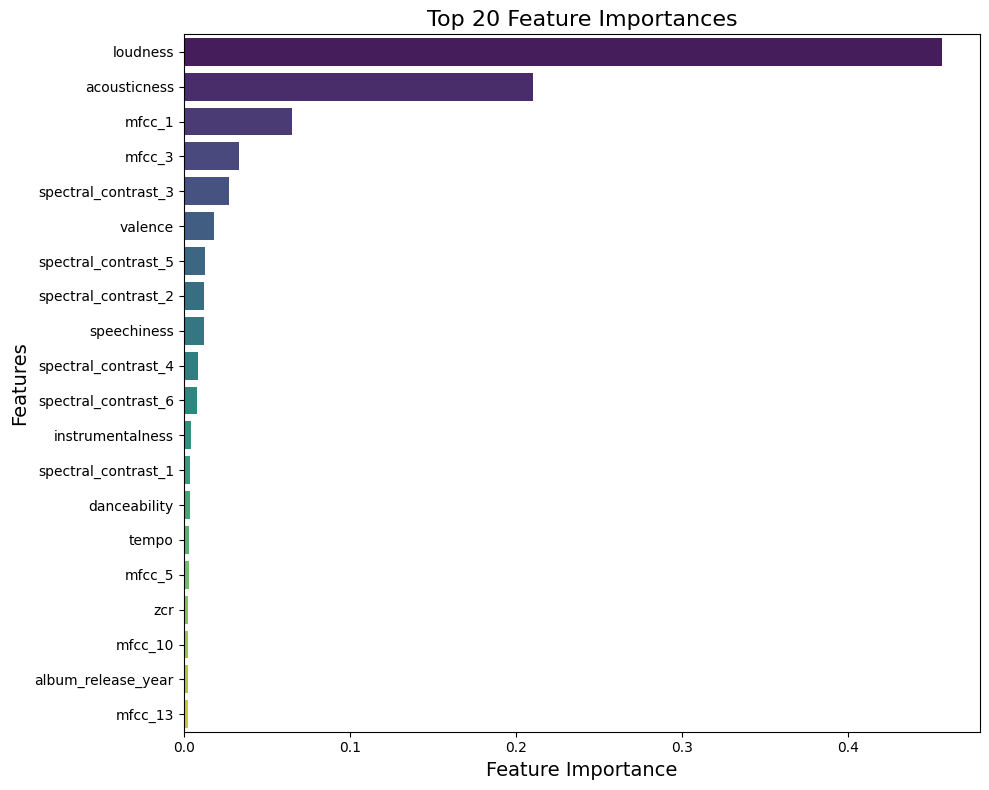

In [301]:

model = final_pipeline.regressor_.named_steps['model']

feature_importances = model.feature_importances_


selected_feature_names = num_features + list(final_pipeline.regressor_.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_features)) if target_transformer else num_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_features))


sorted_idx = np.argsort(feature_importances)[::-1][:20]
top_features = np.array(selected_feature_names)[sorted_idx]
top_importances = feature_importances[sorted_idx]


plt.figure(figsize=(10, 8))
sns.barplot(x=top_importances, y=top_features, palette="viridis")
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 20 Feature Importances', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.inspection import permutation_importance


X_test_transformed = final_pipeline.regressor_.named_steps['preprocessor'].transform(X_test)





selected_feature_names = num_features + list(final_pipeline.regressor_.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_features))





shap_values_with_names = shap.Explanation(values=shap_values, feature_names=selected_feature_names)

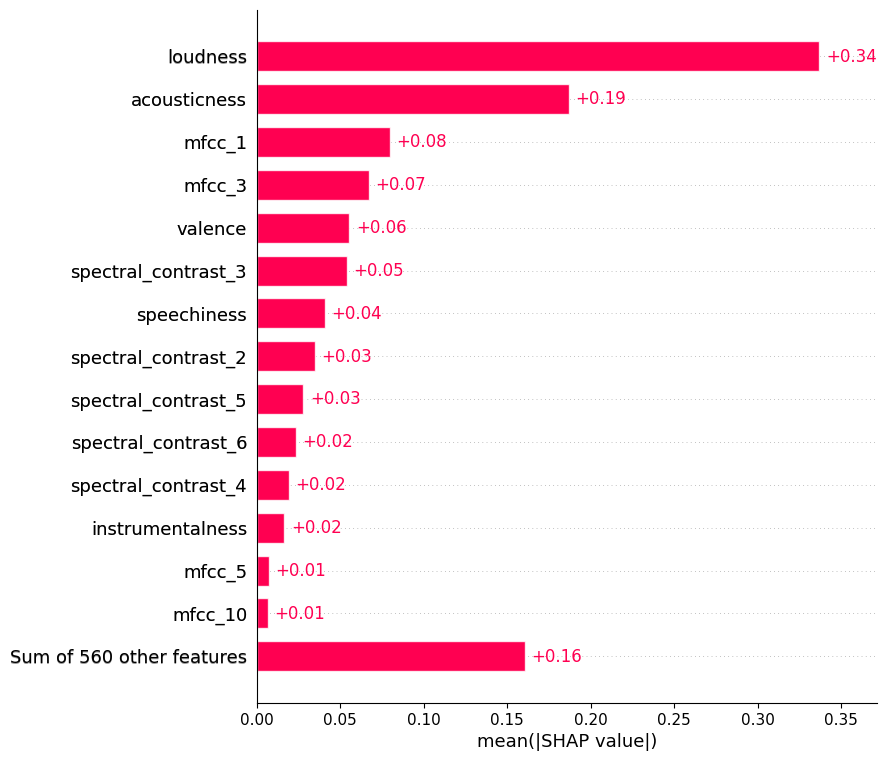

In [ ]:

shap.plots.bar(shap_values_with_names, max_display=15)

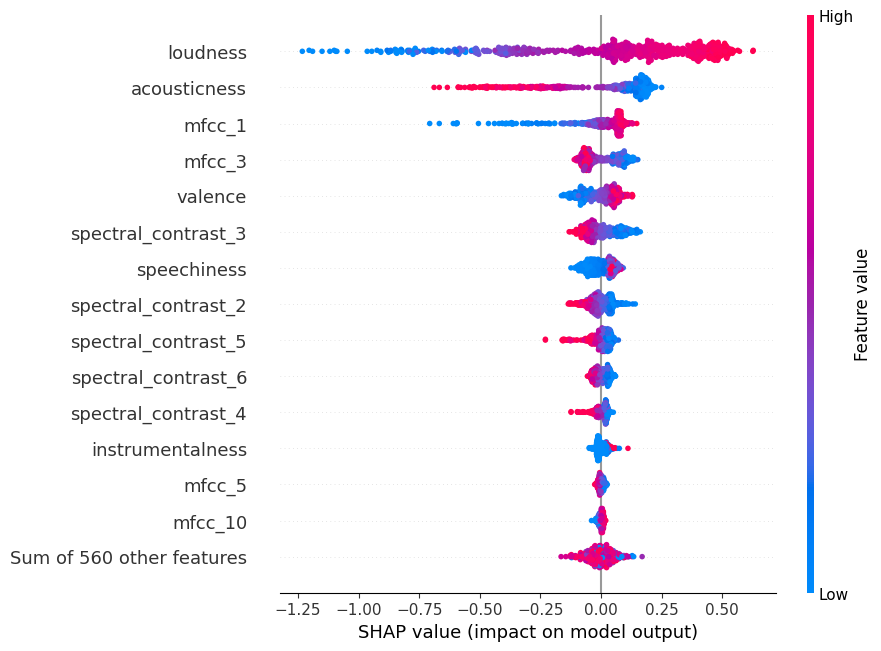

In [338]:
shap.plots.beeswarm(shap_values_with_names, max_display=15)

In [382]:
target = 'mode'

In [383]:
cat_features = [ f for f in df.select_dtypes(include=['category']).columns if f != target ]
num_features = [ f for f in df.select_dtypes(include=['number']).columns if f != target ]

In [384]:
df.head()

,title,artist,mp3_path,lyrics,popularity,explicit,album_release_year,duration_ms,danceability,energy,...,young,za,ça,świat,że,noun_count,verb_count,vader_compound,repetition_count,average_syllables_per_word
0,skinny love,birdy,/home/krystian/Python/Jupyter-projects/thesis/...,"Come on, skinny love, just last the year\nPour...",71.0,False,2011,201080,0.379,0.290,...,0.0,0.0,0.0,0.0,0.0,39,42,0.9820,36,1.123016
1,deathwish,red sun rising,/home/krystian/Python/Jupyter-projects/thesis/...,Life is fleeting by the slow\nIt chills us to ...,NaN,False,2018,287946,0.508,0.882,...,0.0,0.0,0.0,0.0,0.0,69,89,-0.6506,68,1.167513
2,iris,the goo goo dolls,/home/krystian/Python/Jupyter-projects/thesis/...,And I'd give up forever to touch you\n'Cause I...,71.0,False,2007,289906,0.291,0.790,...,0.0,0.0,0.0,0.0,0.0,19,86,-0.5983,29,1.150407
3,the woods,hollow coves,/home/krystian/Python/Jupyter-projects/thesis/...,No lyrics found,NaN,False,2017,241546,0.802,0.410,...,0.0,0.0,0.0,0.0,0.0,1,1,-0.2960,0,1.333333
4,don't dream it's over,crowded house,/home/krystian/Python/Jupyter-projects/thesis/...,There is freedom within\nThere is freedom with...,NaN,False,2017,231377,0.403,0.746,...,0.0,0.0,0.0,0.0,0.0,58,61,-0.9925,47,1.187251


In [385]:

X = df[num_features + cat_features]
y = df[target]

---

In [387]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


target_transformer = Pipeline(steps=[
    ('log_transformer', FunctionTransformer(np.log1p, inverse_func=np.expm1, check_inverse=False)),
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features),
    ]
)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    
    ('model', model)
])

final_pipeline = model_pipeline
final_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['popularity',
                                                   'album_release_year',
                                                   'duration_ms',
                                                   'danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'mfcc_1', 'mfcc_2',
                                                   'mfcc_3', 'mfcc_4', 'mfcc_5',
                                                   'mfcc_6', 'mfcc_7', 'mfcc_8',
                                                   'mfcc_9', 'mfcc_10',
                                                   'mfcc_11', 'mfcc_12',
                                                   'mfcc_13', 'chroma_1',
                                                   'chroma_2', 'chroma_3',
                                                   'chroma_4', 'chroma_5', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['key', 'time_signature'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [388]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['popularity',
                                                   'album_release_year',
                                                   'duration_ms',
                                                   'danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'mfcc_1', 'mfcc_2',
                                                   'mfcc_3', 'mfcc_4', 'mfcc_5',
                                                   'mfcc_6', 'mfcc_7', 'mfcc_8',
                                                   'mfcc_9', 'mfcc_10',
                                                   'mfcc_11', 'mfcc_12',
                                                   'mfcc_13', 'chroma_1',
                                                   'chroma_2', 'chroma_3',
                                                   'chroma_4', 'chroma_5', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['key', 'time_signature'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [391]:
def evaluate_classification_model(y_true, y_pred):
    """Evaluates the classification model and returns a clean dataframe for metrics, with accuracy separately."""
    
    
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    
    
    report_df = pd.DataFrame(report_dict).transpose()

    
    report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].round(3)

    
    accuracy = accuracy_score(y_true, y_pred)
    
    
    if 'accuracy' in report_df.index:
        report_df = report_df.drop('accuracy')

    
    report_df = report_df[['precision', 'recall', 'f1-score', 'support']]
    
    return report_df, accuracy

In [393]:
y_pred = final_pipeline.predict(X_test)

eval_results = evaluate_classification_model(y_test, y_pred)
eval_results[0]

,precision,recall,f1-score,support
0,0.638,0.136,0.225,220.0
1,0.654,0.955,0.776,376.0
macro avg,0.646,0.546,0.500,596.0
weighted avg,0.648,0.653,0.573,596.0


In [394]:
eval_results[1]

0.6526845637583892

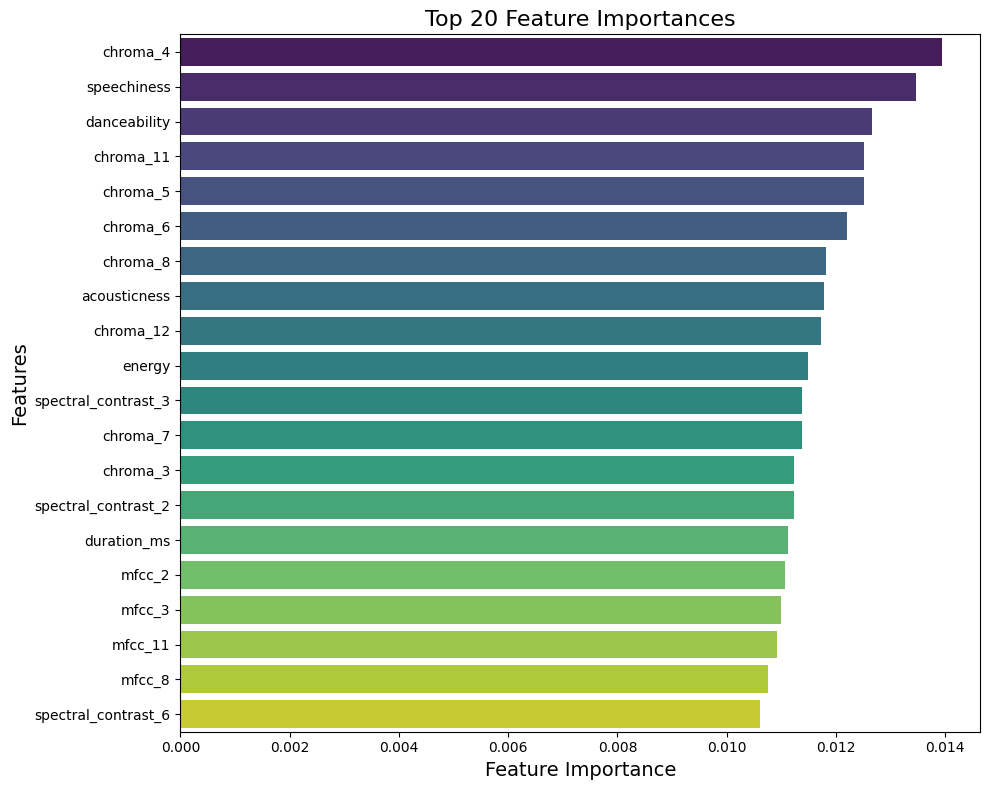

In [397]:

model = final_pipeline.named_steps['model']

feature_importances = model.feature_importances_


selected_feature_names = num_features + list(final_pipeline.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_features)) if target_transformer else num_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_features))


sorted_idx = np.argsort(feature_importances)[::-1][:20]
top_features = np.array(selected_feature_names)[sorted_idx]
top_importances = feature_importances[sorted_idx]


plt.figure(figsize=(10, 8))
sns.barplot(x=top_importances, y=top_features, palette="viridis")
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 20 Feature Importances', fontsize=16)
plt.tight_layout()
plt.show()

In [400]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.inspection import permutation_importance


X_test_transformed = final_pipeline.named_steps['preprocessor'].transform(X_test)





selected_feature_names = num_features + list(final_pipeline.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_features))





shap_values_with_names = shap.Explanation(values=shap_values, feature_names=selected_feature_names)

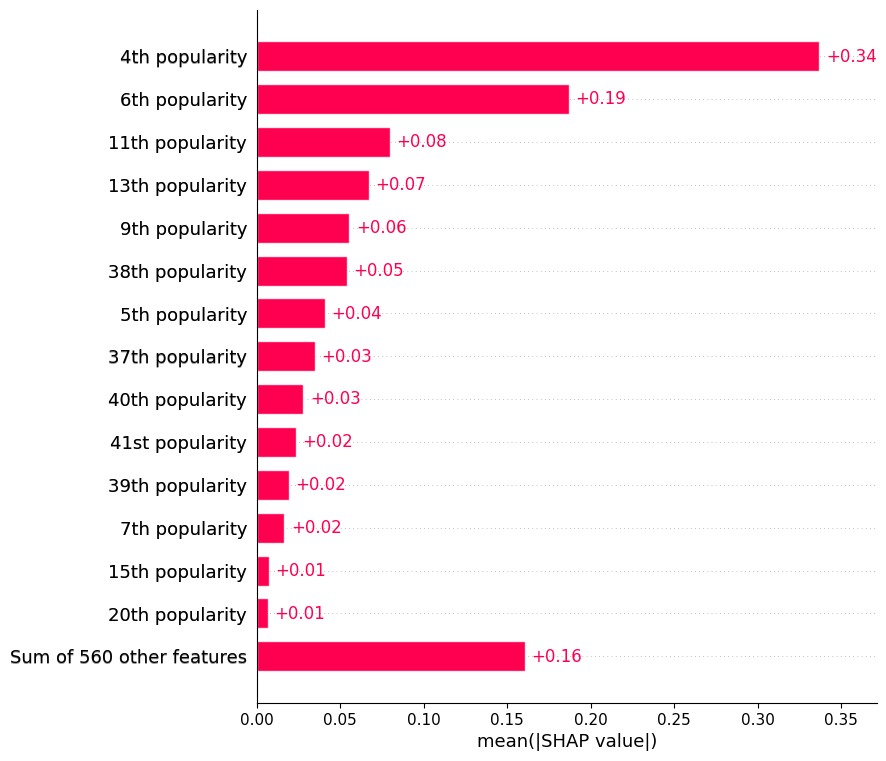

In [401]:

shap.plots.bar(shap_values_with_names, max_display=15)